In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Models')
sys.path.append('../Protocols')
from cell_models import kernik, protocols, paci_2018

import mod_protocols
import protocol_lib
import mod_kernik as kernik
import mod_trace as trace
from Models.br1977 import BR1977
from ord2011 import ORD2011
import model_response

In [2]:
trial_conditions = "BR1977_360_51_4_-121_61_10_5"
prestep = 5000
window = 10
step_size = 5
holding_step = 500
only_end = False
with_artefact =False
model_name = trial_conditions.split('_')[0]

path_to_data = f"ga_results/{trial_conditions}"
files = os.listdir(path_to_data)
for f in files:
    if ('pkl' in f) and (f'p{prestep}' in f) and (f'h{holding_step}' in f) and (f'oe{only_end}' in f):
        file_name = f
print(file_name)
final_protocol = pickle.load(open(f"{path_to_data}/{file_name}", 'rb'))
# print("="*50)
# print(final_protocol)
# print("="*50)
print(f'The protocol is {final_protocol.get_voltage_change_endpoints()[-1]} ms')

# times = np.arange(0, short_protocol.get_voltage_change_endpoints()[-1], 1)         
# print(times.shape)
# short_protocol.plot_voltage_clamp_protocol(times)    

BR1977_360_51_4_-121_61_10_5_h500_p5000_oeFalse_aFalse.pkl
The protocol is 5450.0 ms


In [3]:
start_time = time.time()

currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_CaL', 'I_K1', 'I_NaL' ]               
tr = None
if model_name=='ORD2011' :
    model = ORD2011(final_protocol)
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='OHara2017':
    model = '../mmt-model-files/ohara-cipa-v1-2017_VC.mmt'
    tr = model_response.get_model_response_with_myokit(model, final_protocol, prestep=prestep)
elif model_name=='BR1977' :
    currents = ['I_Na', 'I_si', 'I_K1', 'I_x1']
    model = BR1977(final_protocol)  
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='Kernik':
    currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_F', 'I_CaL', 'I_K1'] 
    k = kernik.KernikModel(is_exp_artefact=True)        
    tr = k.generate_response(final_protocol, is_no_ion_selective=False)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.095181941986084 seconds ---


In [4]:
start_time = time.time()
current_contributions = tr.current_response_info.get_current_contributions( time=tr.t, window=window, step_size=step_size)
total_current = tr.current_response_info.get_current_summed()
c_li = {}
for current_name in currents:
    c = []
    for t in tr.t:    
        idx = current_contributions['Time Mid'].sub(t).abs().idxmin()
        c.append(current_contributions[current_name].loc[idx])        
    c_li[current_name] = c
print("--- %s seconds ---"%(time.time()-start_time))

--- 9.742347717285156 seconds ---


In [5]:
current_contributions

Time Start  Time End  Time Mid      I_Na      I_si      I_K1      I_x1
0              0        10       5.0  0.244757  0.048545  0.706447  0.000251
1              5        15      10.0  0.244757  0.048545  0.706447  0.000251
2             10        20      15.0  0.244757  0.048545  0.706447  0.000251
3             15        25      20.0  0.244757  0.048545  0.706447  0.000251
4             20        30      25.0  0.244757  0.048545  0.706447  0.000251
...          ...       ...       ...       ...       ...       ...       ...
1084        5420      5430    5425.0  0.869548  0.072435  0.022905  0.035112
1085        5425      5435    5430.0  0.878135  0.073727  0.023131  0.025007
1086        5430      5440    5435.0  0.883433  0.075443  0.023270  0.017854
1087        5435      5445    5440.0  0.886556  0.077262  0.023353  0.012829
1088        5440      5450    5445.0  0.888259  0.079015  0.023397  0.009328

[1089 rows x 7 columns]

In [6]:
max_contributions = tr.current_response_info.get_max_current_contributions(tr.t, window=window, step_size=step_size)
max_contributions

Current  Contribution  Time Start  Time End
0    I_Na      0.969838       540.0     550.0
1    I_si      0.938710      1165.0    1175.0
2    I_K1      0.976376      1910.0    1920.0
3    I_x1      0.733654      5350.0    5360.0

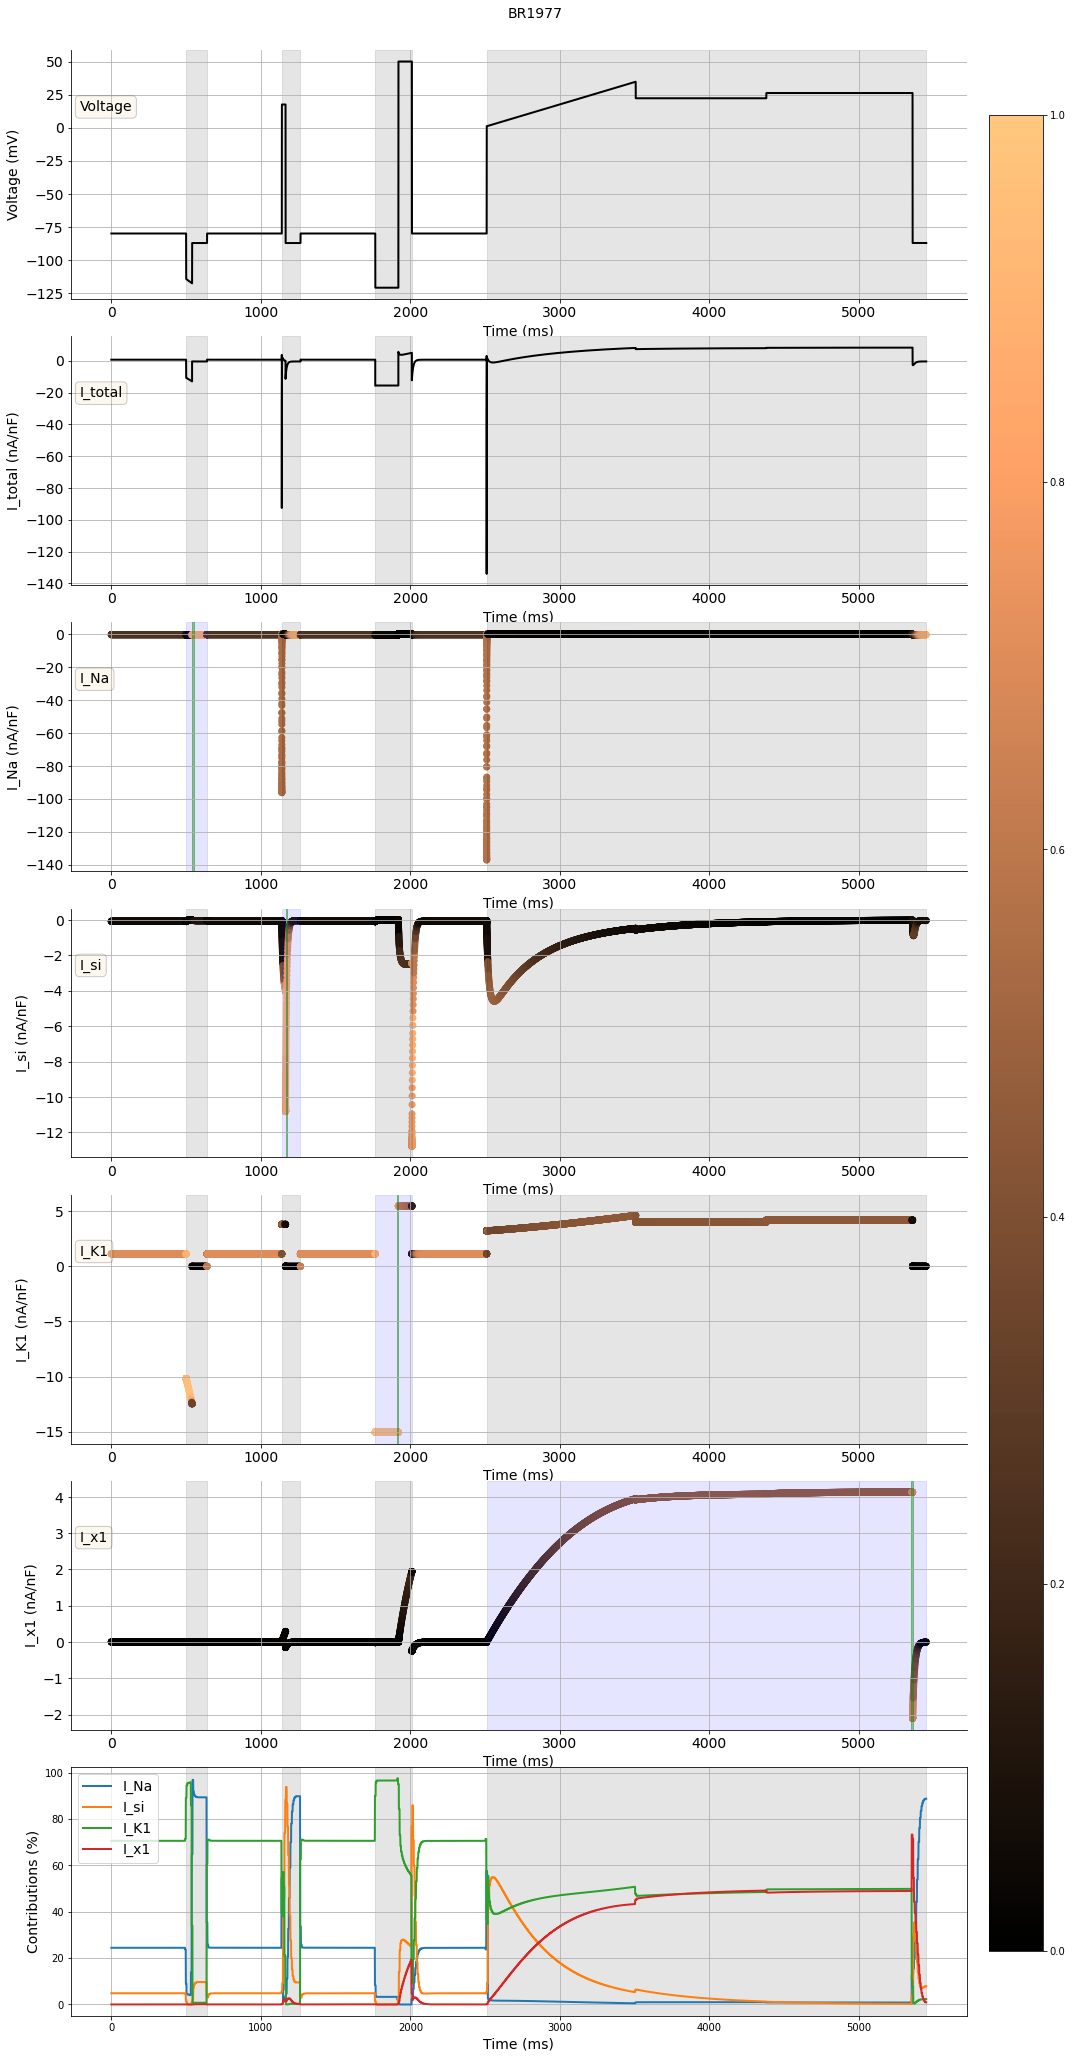

In [13]:
'''
Plot
'''
fig, ax = plt.subplots(len(currents)+3,1, figsize=(15,30))    
fig.suptitle(model_name, fontsize=14)
total_duration = holding_step
for i, name in enumerate(['Voltage', 'I_total' ] + currents):        
#     ax[i].set_title(name)
    # ax[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax[i].set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)', fontsize=14)           
    ax[i].tick_params(axis="x", labelsize=14)
    ax[i].tick_params(axis="y", labelsize=14)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)     
    ax[i].text(0.01, 0.8, name, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', c='k',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))    
    if i==0:
        ax[i].set_ylabel(f'{name} (mV)', fontsize=14)     
        ax[i].plot( tr.t, final_protocol.get_voltage_clamp_protocol(tr.t), label=name, color='k', linewidth=2)    
    elif i==1:
        ax[i].set_ylabel(f'{name} (nA/nF)', fontsize=14)     
        ax[i].plot( tr.t, tr.current_response_info.get_current_summed(), label=name, color='k', linewidth=2)           
    else:         
        ax[i].set_ylabel(f'{name} (nA/nF)', fontsize=14) 
        ax_im = ax[i].scatter(tr.t, tr.current_response_info.get_current([name]), c=c_li[name], cmap=cm.copper, vmin=0, vmax=1, label=[name, name])                
        short_protocol = pickle.load(open(f"{path_to_data}/short_{name}_p{prestep}_oe{only_end}_a{with_artefact}.pkl", 'rb'))                             
        for j in range(len(currents)+3):                      
            ax[j].axvspan(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1], color='b' if i==j else 'k', alpha=.1)                        
#             ax[j].text(p, 0.8, name, transform=ax[j].transAxes, fontsize=14, verticalalignment='top', bbox=props, c='b')    
        total_duration += short_protocol.get_voltage_change_endpoints()[-1]+holding_step
      
        contribution = max_contributions[max_contributions["Current"]==name]['Contribution'].values[0]
        start = max_contributions[max_contributions["Current"]==name]['Time Start'].values[0]
        end = max_contributions[max_contributions["Current"]==name]['Time End'].values[0]         
        ax[i].axvspan(start, end, color='g', alpha=0.4)   
        
        ax[len(currents)+2].plot( tr.t, np.array(c_li[name])*100, label=name, linewidth=2)  
#         ax[i].text(0.01, 0.8, name, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', c='k',
#                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))              
#     ax[i].legend(loc=2, prop={'size': 14})    
    ax[i].grid()
ax[len(currents)+2].set_xlabel('Time (ms)', fontsize=14)
ax[len(currents)+2].set_ylabel('Contributions (%)', fontsize=14)     
ax[len(currents)+2].legend(loc=2, prop={'size': 14})    
ax[len(currents)+2].grid()
# fig = plt.gcf()
cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
fig.colorbar(ax_im, cax=cbar_ax)
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig( f"{path_to_data}/{trial_conditions}_h{holding_step}_p{prestep}_oe{only_end}_a{with_artefact}.jpg", dpi=200)
plt.close(fig)

In [8]:
# print("Complete")